# GE 461 Introduction to Data Science 2024

# Project 4 – Fall Detection

### Görkem Kadir Solun 22003214

### Notes

Changing the random seeds affects the output.

You may need to update the data path.

You may need to update the figure sizes for pyplot.

### Imports


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import random

# Set random seed
random_state = 96
random.seed(random_state)
np.random.seed(random_state)

### Load Data


In [28]:
# Load the data
# NOTE: This data may need to be configured to the correct path
directory = os.getcwd()
data_path = os.path.join(directory, "data\\falldetection_dataset.csv")

# Read the data with the first row as the data instead of the header
raw_data = pd.read_csv(data_path, header=None)

# Get the labels at the second column
data_labels = raw_data.iloc[:, 1]
data_unique_labels = data_labels.unique()
# Get the rest of the data by removing the first two columns
data_features = raw_data.drop(raw_data.columns[[0, 1]], axis=1)

print("Data shape: ", data_features.shape)
print("Labels shape: ", data_labels.shape)
print("Unique labels: ", data_unique_labels)

""" print("Data: ", data)
print("Labels: ", labels) """

Data shape:  (566, 306)
Labels shape:  (566,)
Unique labels:  ['F' 'NF']


' print("Data: ", data)\nprint("Labels: ", labels) '

## Part A

### PCA

Applied PCA to the data to reduce the dimensionality of the data to 2.


Principal Components shape:  (566, 2)
Explained Variance Ratios:  [0.75307248 0.0851159 ]
Eigenvalues:  [31464.17423647  3556.2334265 ]
Total Explained Variance Percentage:  83.81883815238375


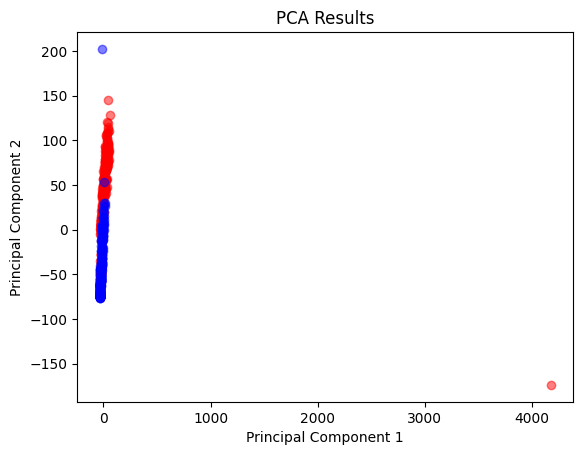

In [29]:
# Apply PCA to the data to reduce the dimensionality of the data to 2
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_features)
explained_variance_ratios = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_
total_explained_variance_percentage = sum(explained_variance_ratios) * 100

print("Principal Components shape: ", principal_components.shape)
print("Explained Variance Ratios: ", explained_variance_ratios)
print("Eigenvalues: ", eigenvalues)
print("Total Explained Variance Percentage: ", total_explained_variance_percentage)


# Function to plot the PCA results with the labels
def plot_pca_results(principal_components, labels, title):
    # Plot the PCA results
    plt.figure()
    # First scatter the fall points
    plt.scatter(
        principal_components[labels == "F", 0],
        principal_components[labels == "F", 1],
        c="r",
        label="Fall",
        alpha=0.5,
    )
    # Then scatter the Non-fall points
    plt.scatter(
        principal_components[labels == "NF", 0],
        principal_components[labels == "NF", 1],
        c="b",
        label="Non-Fall",
        alpha=0.5,
    )
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(title)
    plt.show()


# Plot the PCA results
plot_pca_results(principal_components, data_labels, "PCA Results")

Removed the two maximum outliers that can be detected from the previous plot.


Principal Components without outliers shape:  (564, 2)
Labels without outliers shape:  (564,)
Data without outliers shape:  (564, 306)


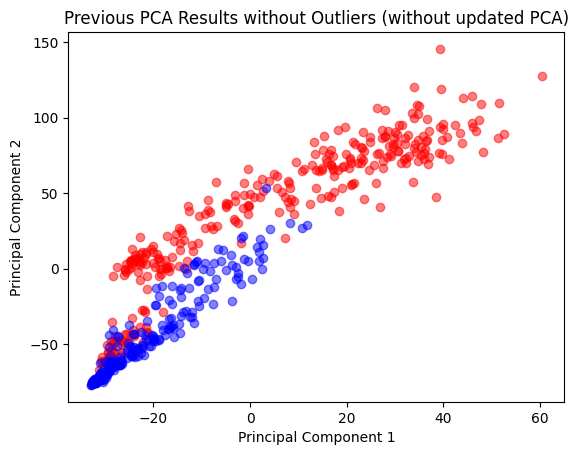

In [30]:
# Remove the first maximum outlier from the first principal component

max_index = np.argmax(principal_components[:, 0])
principal_components_no_outliers = np.delete(principal_components, max_index, axis=0)
labels_no_outlier = np.delete(data_labels, max_index, axis=0)
data_features_no_outlier = np.delete(data_features, max_index, axis=0)

# Remove the first maximum outlier from the second principal component
max_index = np.argmax(principal_components_no_outliers[:, 1])
principal_components_no_outliers = np.delete(
    principal_components_no_outliers, max_index, axis=0
)
labels_no_outlier = np.delete(labels_no_outlier, max_index, axis=0)
data_features_no_outlier = np.delete(data_features_no_outlier, max_index, axis=0)

print(
    "Principal Components without outliers shape: ",
    principal_components_no_outliers.shape,
)
print("Labels without outliers shape: ", labels_no_outlier.shape)
print("Data without outliers shape: ", data_features_no_outlier.shape)

# Plot the previous PCA results without the outliers
# NOTE: The outliers are removed from the data and labels, so we need to calculate the PCA again
# to get the principal components without the outliers, this is just for visualization purposes
plot_pca_results(
    principal_components_no_outliers,
    labels_no_outlier,
    "Previous PCA Results without Outliers (without updated PCA)",
)

Applied PCA again to data without outliers.


Principal Components without outliers shape:  (564, 2)
Explained Variance Ratios without outliers:  [0.40272259 0.18999792]
Eigenvalues without outliers:  [3962.56193172 1869.47175434]
Total Explained Variance Percentage without outliers:  59.27205104560262


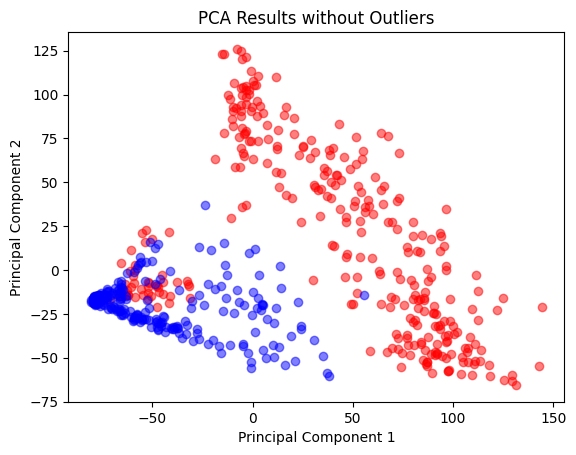

In [31]:
# Applay PCA to data withou outliers
pca_no_outliers = PCA(n_components=2)
principal_components_no_outliers = pca_no_outliers.fit_transform(
    data_features_no_outlier
)
explained_variance_ratios_no_outliers = pca_no_outliers.explained_variance_ratio_
eigenvalues_no_outliers = pca_no_outliers.explained_variance_
total_explained_variance_percentage_no_outliers = (
    sum(explained_variance_ratios_no_outliers) * 100
)

print(
    "Principal Components without outliers shape: ",
    principal_components_no_outliers.shape,
)
print(
    "Explained Variance Ratios without outliers: ",
    explained_variance_ratios_no_outliers,
)
print("Eigenvalues without outliers: ", eigenvalues_no_outliers)
print(
    "Total Explained Variance Percentage without outliers: ",
    total_explained_variance_percentage_no_outliers,
)

plot_pca_results(
    principal_components_no_outliers, labels_no_outlier, "PCA Results without Outliers"
)

Scaled the data with Min-Max scaling to normalize the data and get better results.
Transformed the labels to binary, F=1, NF=0.


In [32]:
# Scale the data with the MinMaxScaler to normalize the data
min_max_scaler = MinMaxScaler()
data_features_scaled = min_max_scaler.fit_transform(data_features_no_outlier)
# Transform the labels to binary, F=1, NF=0 for the binary classification in the future
data_labels_binary = np.where(labels_no_outlier == "F", 1, 0)

Applied PCA again to normalized data.


Principal Components normalized shape:  (564, 2)
Explained Variance Ratios normalized:  [0.2664839  0.22066081]
Eigenvalues normalized:  [2.288873   1.89529111]
Total Explained Variance Percentage normalized:  48.71447026228686


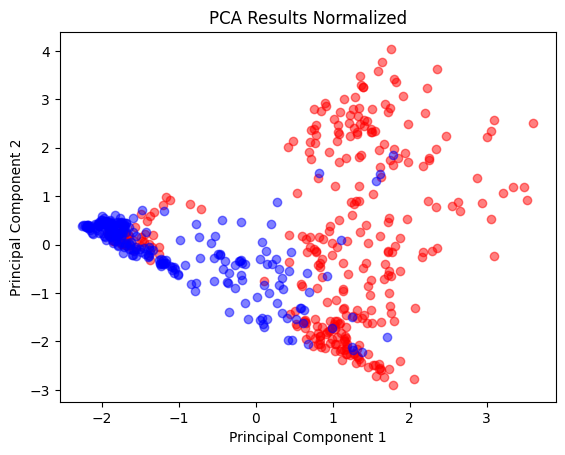

In [33]:
# Apply PCA again to data without outliers
pca_normalized = PCA(n_components=2)
principal_components_normalized = pca_normalized.fit_transform(data_features_scaled)
explained_variance_ratios_normalized = pca_normalized.explained_variance_ratio_
eigenvalues_normalized = pca_normalized.explained_variance_
total_explained_variance_percentage_normalized = (
    sum(explained_variance_ratios_normalized) * 100
)

print("Principal Components normalized shape: ", principal_components_normalized.shape)
print("Explained Variance Ratios normalized: ", explained_variance_ratios_normalized)
print("Eigenvalues normalized: ", eigenvalues_normalized)
print(
    "Total Explained Variance Percentage normalized: ",
    total_explained_variance_percentage_normalized,
)

plot_pca_results(
    principal_components_normalized, labels_no_outlier, "PCA Results Normalized"
)

Applied K-means


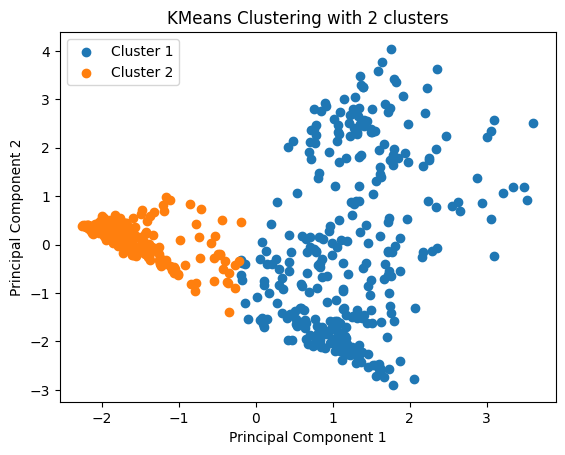

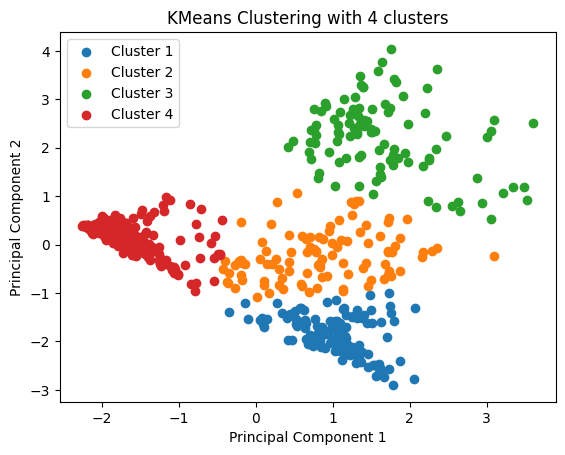

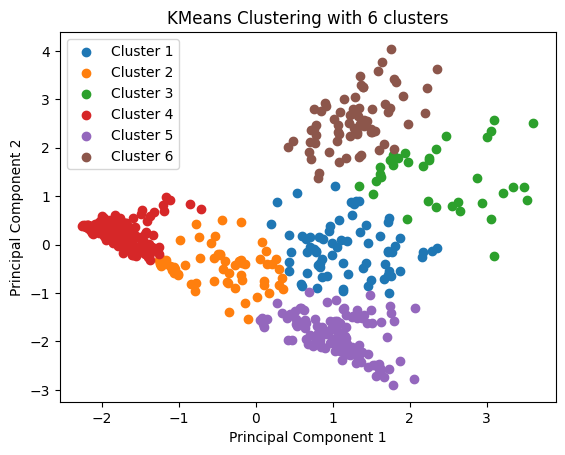

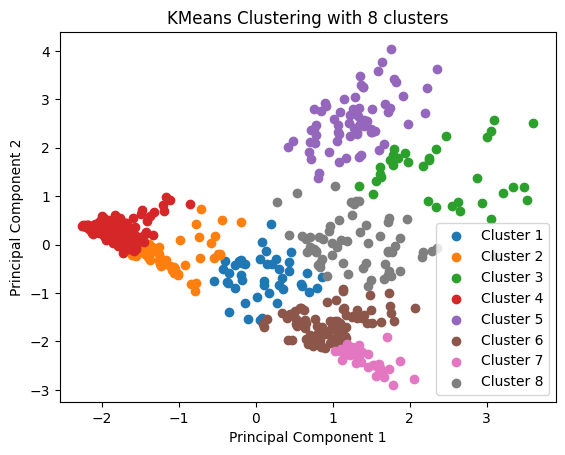

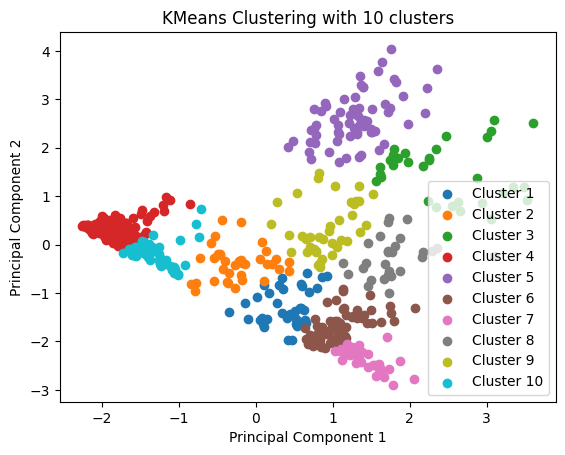

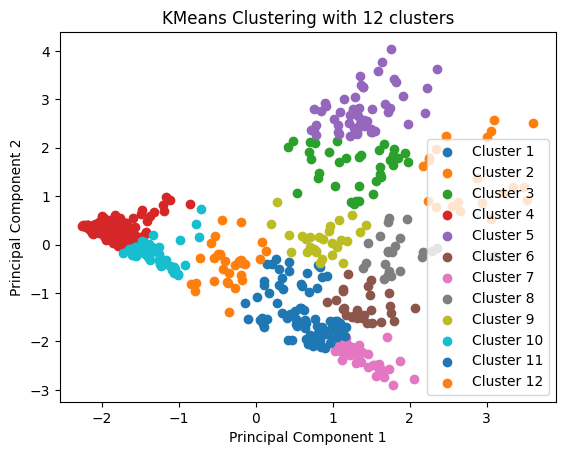

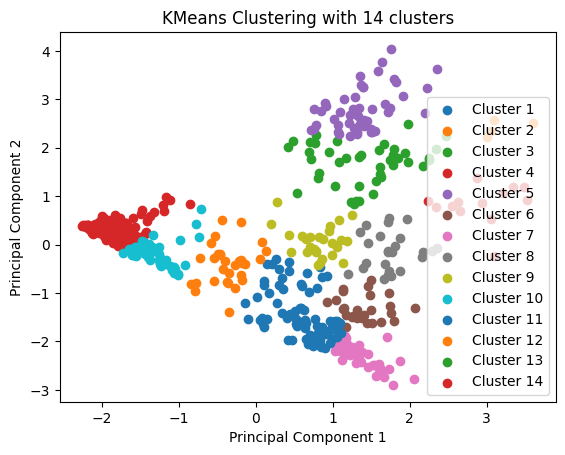

In [34]:
# Plotting function to plot the KMeans clustering results for different number of clusters
def plot_kmeans_results(principal_components, labels, n_clusters):
    plt.figure()
    for i in range(n_clusters):
        plt.scatter(
            principal_components[labels == i, 0],
            principal_components[labels == i, 1],
            label="Cluster " + str(i + 1),
        )
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("KMeans Clustering with " + str(n_clusters) + " clusters")
    plt.legend()
    plt.show()


# Inertia values for different number of clusters
inertia_values = []

# Apply KMeans clustering to the normalized data withe different number of clusters
for n_clusters in range(2, 16):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(principal_components_normalized)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    inertia_values.append(kmeans.inertia_)

    # Plot the KMeans clustering results for different number of clusters
    if n_clusters % 2 == 0:
        plot_kmeans_results(principal_components_normalized, labels, n_clusters)

Inertia of K-means


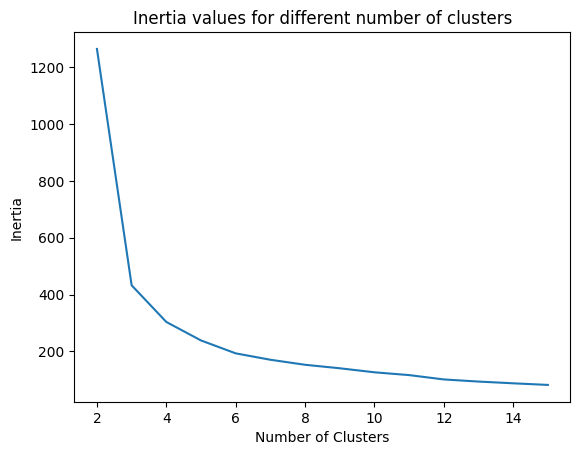

In [35]:
# Plot the inertia values for different number of clusters
plt.figure()
plt.plot(range(2, 16), inertia_values)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Inertia values for different number of clusters")
plt.show()

# Part B

### SVM


In [36]:
# Apply SVM to the normalized data

# First split the normalized data into training, validation and testing sets
# 70% training, 15% validation, 15% testing
data_train, data_test, labels_train, labels_test = train_test_split(
    data_features_scaled, data_labels_binary, test_size=0.15, random_state=random_state
)

data_train, data_val, labels_train, labels_val = train_test_split(
    data_train, labels_train, test_size=0.1765, random_state=random_state
)

# Find the best hyperparameters for the SVM model
# Use GridSearchCV to find the best hyperparameters for the SVM model
# Create two dictionaries for the hyperparameters to search for
# One is for polynomial kernel and the other is for rbf, linear, and sigmoid kernels
param_grid_poly = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "degree": [2, 3, 4, 5],
    "gamma": ["scale", "auto"],
    "kernel": ["poly"],
}

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "gamma": ["scale", "auto"],
    "kernel": ["rbf", "linear", "sigmoid"],
}

# Search for the best hyperparameters for the polynomial kernel
svm_poly = SVC()
svm_poly_search = GridSearchCV(svm_poly, param_grid_poly, cv=3)
svm_poly_search.fit(data_train, labels_train)
grid_results_poly = svm_poly_search.cv_results_

# Search for the best hyperparameters for the rbf, linear, and sigmoid kernels
svm = SVC()
svm_search = GridSearchCV(svm, param_grid, cv=3)
svm_search.fit(data_train, labels_train)
grid_results = svm_search.cv_results_

# Combine the results of the polynomial kernel and the rbf, linear, and sigmoid kernels
# and sort them by the mean_test_score

# Combine the results
results = []
for i in range(len(grid_results["mean_test_score"])):
    results.append(
        {
            "mean_test_score": grid_results["mean_test_score"][i],
            "params": grid_results["params"][i],
        }
    )

for i in range(len(grid_results_poly["mean_test_score"])):
    results.append(
        {
            "mean_test_score": grid_results_poly["mean_test_score"][i],
            "params": grid_results_poly["params"][i],
        }
    )

# Sort the results by the mean_test_score
results = sorted(results, key=lambda x: x["mean_test_score"], reverse=True)

# Show the hyperparameters in the dataframe nicely
results_df = pd.DataFrame(results)
print("Results: ", results_df)

Results:      mean_test_score                                             params
0           1.00000       {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
1           1.00000      {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
2           1.00000       {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
3           1.00000   {'C': 100, 'gamma': 'auto', 'kernel': 'sigmoid'}
4           1.00000  {'C': 0.1, 'degree': 4, 'gamma': 'scale', 'ker...
..              ...                                                ...
79          0.54823  {'C': 1, 'degree': 4, 'gamma': 'auto', 'kernel...
80          0.54823  {'C': 1, 'degree': 5, 'gamma': 'auto', 'kernel...
81          0.54823  {'C': 10, 'degree': 4, 'gamma': 'auto', 'kerne...
82          0.54823  {'C': 10, 'degree': 5, 'gamma': 'auto', 'kerne...
83          0.54823  {'C': 100, 'degree': 5, 'gamma': 'auto', 'kern...

[84 rows x 2 columns]


Best SVM classifier


Best Hyperparameters:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy on the validation set:  1.0
Accuracy on the test set:  1.0
Confusion Matrix:  [[36  0]
 [ 0 49]]


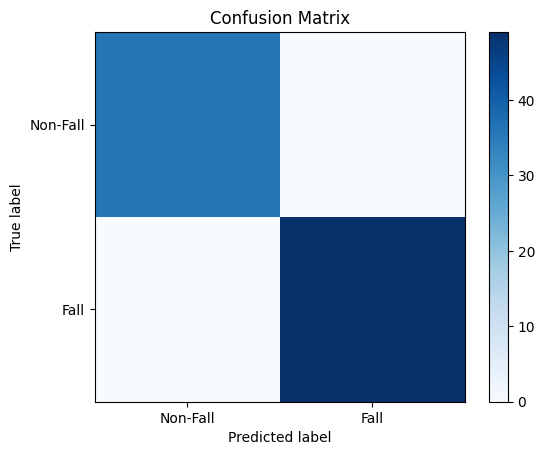

In [37]:
# Get the best hyperparameters
best_hyperparameters = results[0]["params"]
print("Best Hyperparameters: ", best_hyperparameters)

# Train the SVM model with the best hyperparameters
svm_best = SVC(**best_hyperparameters)
svm_best.fit(data_train, labels_train)

# Get the accuracy of the model on the validation set
accuracy_val = svm_best.score(data_val, labels_val)
print("Accuracy on the validation set: ", accuracy_val)

# Get the accuracy of the model on the test set
accuracy_test = svm_best.score(data_test, labels_test)
print("Accuracy on the test set: ", accuracy_test)

# Get the confusion matrix of the model on the test set
labels_pred = svm_best.predict(data_test)
conf_matrix = confusion_matrix(labels_test, labels_pred)
print("Confusion Matrix: ", conf_matrix)

# Plot the confusion matrix
plt.figure()
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Non-Fall", "Fall"])
plt.yticks(tick_marks, ["Non-Fall", "Fall"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

### MLP


In [38]:
# Apply MLP to the normalized data

# Find the best hyperparameters for the MLP model
# Use GridSearchCV to find the best hyperparameters for the MLP model

# Create a dictionary for the hyperparameters to search for
param_grid_mlp = {
    "hidden_layer_sizes": [
        (1,),
        (2,),
        (3,),
        (4,),
        (5,),
        (6,),
        (7,),
        (8,),
        (9,),
        (10,),
        (11,),
        (12,),
        (13,),
        (14,),
        #        (15,),
        #        (16,),
        #        (17,),
        #        (18,),
        #        (19,),
        #        (20,),
        #        (21,),
        #        (22,),
        #        (23,),
        #        (24,),
        #        (25,),
        #        (26,),
        #        (27,),
        #        (28,),
        #        (29,),
        #        (30,),
    ],
    "activation": ["identity", "logistic", "tanh", "relu"],
    "solver": ["lbfgs", "sgd", "adam"],
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "learning_rate": ["constant", "invscaling", "adaptive"],
}

# Search for the best hyperparameters for the MLP model
mlp = MLPClassifier()
mlp_search = GridSearchCV(mlp, param_grid_mlp, cv=3, scoring="accuracy", n_jobs=-1)
mlp_search.fit(data_train, labels_train)

GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                (6,), (7,), (8,), (9,), (10,),
                                                (11,), (12,), (13,), (14,)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='accuracy')

Best MLP


Best Hyperparameters for MLP:  {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (9,), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
Accuracy on the validation set for MLP:  1.0
Accuracy on the test set for MLP:  1.0
Confusion Matrix for MLP:  [[36  0]
 [ 0 49]]


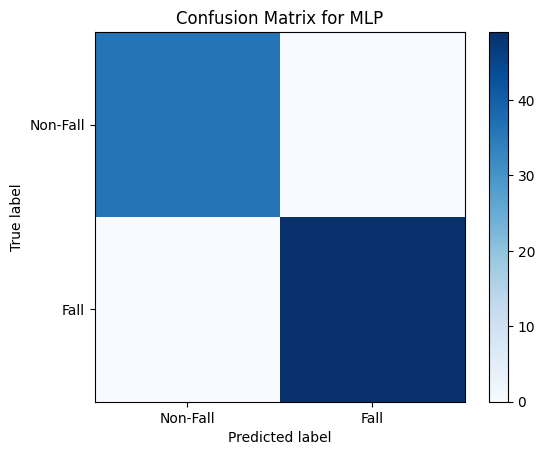

In [39]:
# Get the best hyperparameters
best_hyperparameters_mlp = mlp_search.best_params_
print("Best Hyperparameters for MLP: ", best_hyperparameters_mlp)

# Train the MLP model with the best hyperparameters
mlp_best = MLPClassifier(**best_hyperparameters_mlp)
mlp_best.fit(data_train, labels_train)

# Get the accuracy of the model on the validation set
accuracy_val_mlp = mlp_best.score(data_val, labels_val)
print("Accuracy on the validation set for MLP: ", accuracy_val_mlp)

# Get the accuracy of the model on the test set
accuracy_test_mlp = mlp_best.score(data_test, labels_test)
print("Accuracy on the test set for MLP: ", accuracy_test_mlp)

# Get the confusion matrix of the model on the test set
labels_pred_mlp = mlp_best.predict(data_test)
conf_matrix_mlp = confusion_matrix(labels_test, labels_pred_mlp)
print("Confusion Matrix for MLP: ", conf_matrix_mlp)

# Plot the confusion matrix
plt.figure()
plt.imshow(conf_matrix_mlp, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MLP")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Non-Fall", "Fall"])
plt.yticks(tick_marks, ["Non-Fall", "Fall"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()